In [2]:
import pandas as pd
from nba_api.stats.endpoints import teamdashboardbylastngames
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import leaguedashteamstats

In [1]:
seasons = [
    '2009-10',
    '2010-11',
    '2011-12',
    '2012-13',
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2019-20',
    '2020-21',
    '2021-22',
    '2022-23',
]

In [ ]:
# Q: What is brooklyn's team id?
# A: 1610612751

In [4]:
# Set team id and team abbr
# team_id = 1610612760 (Thunder)
team_abbr = "MIN"
team_id = 1610612750

# Function to determine if game was home or away
def home_away(row):
    if row['MATCHUP'].find('@') == -1:
        return 'H'
    else:
        return 'A'

# Loop through all seasons and collect gamelogs
team_gamelogs = []
for year in seasons:
    temp_df = teamgamelogs.TeamGameLogs(
                team_id_nullable=team_id, 
                season_nullable=year,
                measure_type_player_game_logs_nullable='Advanced',
                per_mode_simple_nullable='Per48',
                ).get_data_frames()[0]
    temp_df.sort_values(by='GAME_DATE', inplace=True)
    temp_df['GAME_DATE'] = pd.to_datetime(temp_df['GAME_DATE'])
    temp_df['GAME_DATE'] = temp_df['GAME_DATE'].dt.strftime('%Y-%m-%d')
    temp_df['HOME_AWAY'] = temp_df.apply(home_away, axis=1)
    temp_df = temp_df[['TEAM_ID','GAME_ID','GAME_DATE','HOME_AWAY','OFF_RATING','DEF_RATING','PACE','PIE']]
    team_gamelogs.append(temp_df)
team_gamelogs = pd.concat(team_gamelogs)
team_gamelogs.columns = ['team_id','game_id','game_date','home_away','OFF_RATING','DEF_RATING','PACE_','PIE_']

# Collect points scored and against for each game
team_scores = []
for year in seasons:
    temp_df = teamgamelogs.TeamGameLogs(
                team_id_nullable=team_id, 
                season_nullable=year,
                per_mode_simple_nullable='Per48',
                ).get_data_frames()[0]
    temp_df.sort_values(by='GAME_DATE', inplace=True)
    temp_df['PTS'] = temp_df['PTS'].astype(int)
    temp_df = temp_df[['TEAM_ID','GAME_ID','PTS']]
    team_scores.append(temp_df)
team_scores = pd.concat(team_scores)
team_scores.columns = ['team_id','game_id','pts']

# Merge gamelogs/scores and calculate rolling averages
team_score_df = team_gamelogs.copy()
team_score_df = team_score_df.merge(team_scores, how='left', on=['team_id','game_id'])
team_score_df['off_rtg'] = round(team_score_df['OFF_RATING'].rolling(82).mean(), 3)
team_score_df['off_rtg_10'] = round(team_score_df['OFF_RATING'].rolling(10).mean(), 3)
team_score_df['def_rtg'] = round(team_score_df['DEF_RATING'].rolling(82).mean(), 3)
team_score_df['def_rtg_10'] = round(team_score_df['DEF_RATING'].rolling(10).mean(), 3)
team_score_df['pace'] = round(team_score_df['PACE_'].rolling(82).mean(), 3)
team_score_df['pace_10'] = round(team_score_df['PACE_'].rolling(10).mean(), 3)
team_score_df['pie'] = round(team_score_df['PIE_'].rolling(82).mean(), 3)
team_score_df['pie_10'] = round(team_score_df['PIE_'].rolling(10).mean(), 3)
team_score_df = team_score_df[team_score_df['game_date'] >= '2010-09-01']
team_score_df = team_score_df.drop(columns=['OFF_RATING','DEF_RATING','PACE_','PIE_'])
team_score_df.reset_index(drop=True, inplace=True)
team_score_df.to_csv(f"data\\gamelogs\\{team_abbr}_gamelogs.csv", index=False)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [5]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

# Obtain dataset for model training
gpr_gamelogs = okc_score_df.copy()
gpr_gamelogs = gpr_gamelogs[['pts','off_rtg','off_rtg_10','pace','pace_10','pie','pie_10']]
game_Y = gpr_gamelogs['pts']
game_X = gpr_gamelogs.drop(columns=['pts'])

# Train the model and score it
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=3).fit(game_X, game_Y)

In [6]:
test_features = pd.DataFrame({
    'off_rtg': [115.3],
    'off_rtg_10': [103.62],
    'pace': [108.14],
    'pace_10': [99.5],
    'pie': [0.5],
    'pie_10': [0.53],
})

# Get score prediction for fake example
score_dist = gpr.predict(test_features, return_std=True)
mean, std = score_dist
print(f"Predicted Score: {round(mean[0],2)}, StDev: {round(std[0],3)}")

Predicted Score: 102.46, StDev: 10.696


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


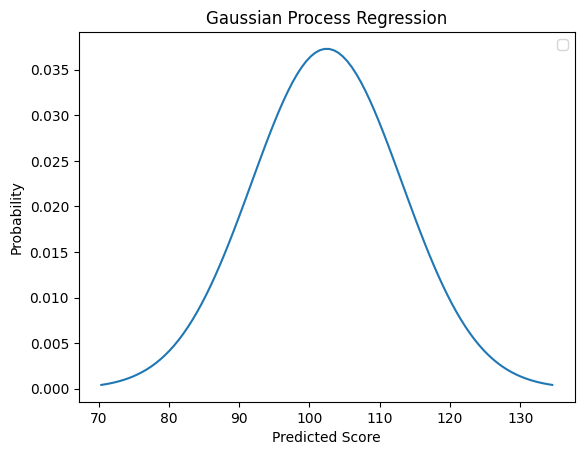

In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# Plot bell curve of predicted scores
x = np.linspace(mean[0] - 3*std[0], mean[0] + 3*std[0], 100)
plt.plot(x, stats.norm.pdf(x, mean[0], std[0]))

# Add legend and labels
plt.legend()
plt.title('Gaussian Process Regression')
plt.xlabel('Predicted Score')
plt.ylabel('Probability')
plt.show()

In [16]:
# Get team stats for season and last 10 games
league_adv = leaguedashteamstats.LeagueDashTeamStats(measure_type_detailed_defense='Advanced').get_data_frames()[0]
league_10_adv = leaguedashteamstats.LeagueDashTeamStats(last_n_games=10, measure_type_detailed_defense='Advanced').get_data_frames()[0]

# Merge season and last 10 game stats
league_adv = league_adv[['TEAM_ID','OFF_RATING','PACE','PIE']]
league_adv.columns = ['team_id','off_rtg','pace','pie']
league_10_adv = league_10_adv[['TEAM_ID','OFF_RATING','PACE','PIE']]
league_10_adv.columns = ['team_id','off_rtg_10','pace_10','pie_10']
league_adv_df = league_adv.merge(league_10_adv, how='left', on='team_id')
league_adv_df = league_adv_df[['team_id','off_rtg','off_rtg_10','pace','pace_10','pie','pie_10']]

In [19]:
# Get predictions for all teams
gpr_league_df = league_adv_df.copy()
gpr_league_df = gpr_league_df.drop(columns=['team_id'])
preds = gpr.predict(gpr_league_df, return_std=True)

# Add predictions to league dataframe
league_adv_df['pred_pts'] = preds[0]
league_adv_df['pred_std'] = preds[1]
league_adv_df['pred_pts'] = league_adv_df['pred_pts'].round(3)
league_adv_df['pred_std'] = league_adv_df['pred_std'].round(3)

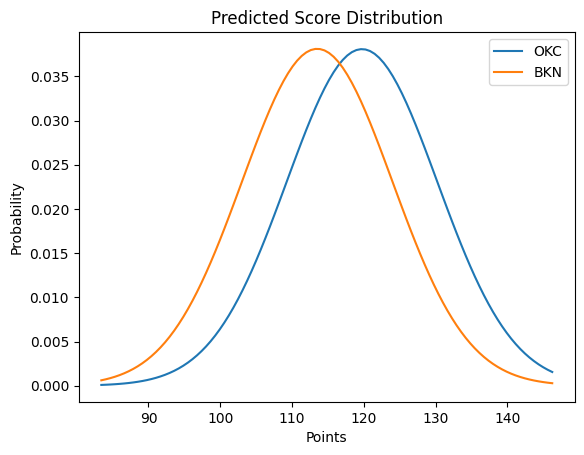

In [25]:
# Get average points and standard deviation for league
avg_pts = league_adv_df['pred_pts'].mean()
avg_std = league_adv_df['pred_std'].mean()
x = np.linspace(avg_pts - 3*avg_std, avg_pts + 3*avg_std, 100)

# Plot OKC's predicted score distribution
okc_pred_pts = league_adv_df[league_adv_df['team_id'] == 1610612760]['pred_pts']
okc_pred_std = league_adv_df[league_adv_df['team_id'] == 1610612760]['pred_std']
plt.plot(x, stats.norm.pdf(x, okc_pred_pts, okc_pred_std), label='OKC')

# Plot Brooklyn's predicted score distribution
bkn_pred_pts = league_adv_df[league_adv_df['team_id'] == 1610612751]['pred_pts']
bkn_pred_std = league_adv_df[league_adv_df['team_id'] == 1610612751]['pred_std']
plt.plot(x, stats.norm.pdf(x, bkn_pred_pts, bkn_pred_std), label='BKN')

# Add legend and labels
plt.legend()
plt.xlabel('Points')
plt.ylabel('Probability')
plt.title('Predicted Score Distribution')
plt.show()